In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statistics
%matplotlib inline
from datetime import datetime
from pandas import Series
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

AttributeError: module 'pandas' has no attribute 'core'

In [ ]:
def stack_footfall(year):
    footfall = pd.read_csv('preprocessing/'+ year +'-01.csv', index_col = 0)
    
    for i in range(11):
        if i < 8:
            footfall = footfall.append(
                pd.read_csv('preprocessing/'+ year +'-0' + str(i + 2) + '.csv', index_col = 0))
        else:
            footfall = footfall.append(
                pd.read_csv('preprocessing/'+ year +'-' + str(i + 2) + '.csv', index_col = 0)) 
            
    
    footfall = footfall.dropna(how = 'any', axis = 0)
    footfall.timestamp = pd.to_datetime(footfall.timestamp, format = '%Y-%m-%d %H:%M:%S') 
    
    return footfall

In [ ]:
ff2018 = stack_footfall('2018')
ff2019 = stack_footfall('2019')
ff2020 = stack_footfall('2020')

In [4]:
ff = ff2018.append(ff2019).append(ff2020)

<AxesSubplot:title={'center':'Footfall Count'}, xlabel='timestamp'>

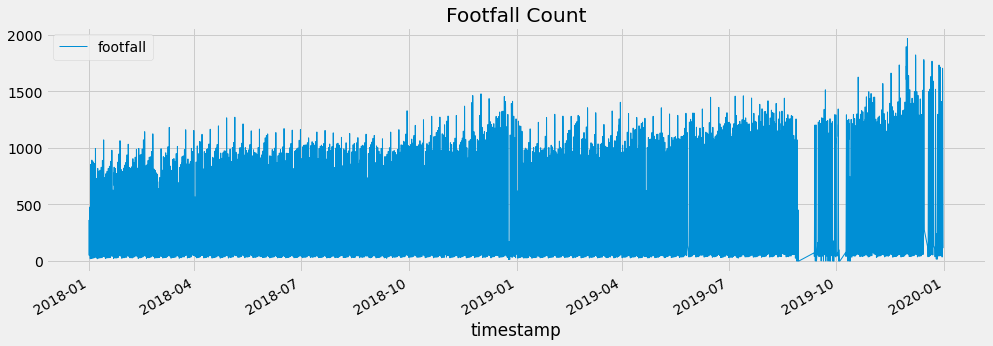

In [5]:
ff = ff.loc[(ff.timestamp >= '2018-01') & (ff.timestamp <= '2019-12-31')]

ff = ff.reset_index(drop = True)
ff_sum = ff.groupby('timestamp')['footfall'].mean().to_frame()
ff_sum.plot(figsize =(15,5), title = "Footfall Count", fontsize = 14, linewidth = 1)

In [3]:
import seaborn as sns
import os
import statistics

In [7]:
ff_sum = ff.groupby('timestamp')['footfall'].mean().to_frame()

#Hourly
hourly = ff_sum.resample('H').mean()

#Daily
daily = ff_sum.resample('D').mean()

#Weekly
weekly = ff_sum.resample('W').mean()

#Monthly
monthly = ff_sum.resample('M').mean()

<AxesSubplot:xlabel='day_of_week'>

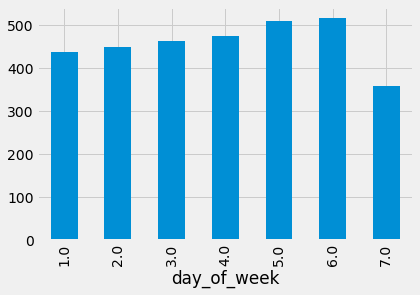

In [8]:
ff.groupby('day_of_week')['footfall'].mean().plot.bar()

<AxesSubplot:xlabel='hour'>

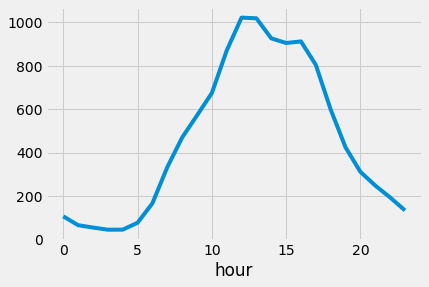

In [9]:
ff.groupby('hour')['footfall'].mean().plot.line()

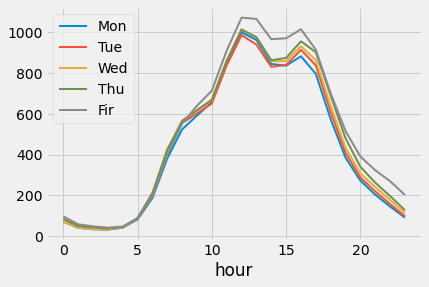

In [10]:
weekday = 1
ff.loc[(ff.day_of_week >= weekday) & (ff.day_of_week <= weekday)].groupby('hour')['footfall'].mean().plot(
    label = 'Mon', linewidth = 2)

weekday = 2
ff.loc[(ff.day_of_week >= weekday) & (ff.day_of_week <= weekday)].groupby('hour')['footfall'].mean().plot(
    label = 'Tue', linewidth = 2)

weekday = 3
ff.loc[(ff.day_of_week >= weekday) & (ff.day_of_week <= weekday)].groupby('hour')['footfall'].mean().plot(
    label = 'Wed', linewidth = 2)

weekday = 4
ff.loc[(ff.day_of_week >= weekday) & (ff.day_of_week <= weekday)].groupby('hour')['footfall'].mean().plot(
    label = 'Thu', linewidth = 2)

weekday = 5
ff.loc[(ff.day_of_week >= weekday) & (ff.day_of_week <= weekday)].groupby('hour')['footfall'].mean().plot(
    label = 'Fir', linewidth = 2)

plt.legend(loc = 'best')

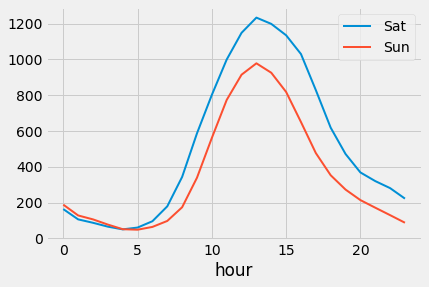

In [11]:
weekday = 6
ff.loc[(ff.day_of_week >= weekday) & (ff.day_of_week <= weekday)].groupby('hour')['footfall'].mean().plot(
    label = 'Sat', linewidth = 2)

weekday = 7
ff.loc[(ff.day_of_week >= weekday) & (ff.day_of_week <= weekday)].groupby('hour')['footfall'].mean().plot(
    label = 'Sun', linewidth = 2)

plt.legend(loc = 'best')

# Time Series Forecasting
## Case Study -- Location 639 (163 High Street):

In [2]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions

### Load the Interpolated Data:

In [29]:
ff = pd.read_csv('stackfootfall.csv')
ff.timestamp = pd.to_datetime(ff.timestamp, format = '%Y-%m-%d %H:%M:%S') 

In [30]:
loc = 5
ff639 = ff.loc[(ff.location <= loc) & (ff.location >= loc) & 
               (ff.timestamp >= '2018-01') & (ff.timestamp <= '2019-08-25')][[
    'timestamp','footfall','year','month','day','hour','day_of_week']]
ff639.index = ff639.timestamp
ff639.head()

,timestamp,footfall,year,month,day,hour,day_of_week
timestamp,,,,,,,
2018-01-01 00:00:00,2018-01-01 00:00:00,494.0,2018,1,1,0,1
2018-01-01 01:00:00,2018-01-01 01:00:00,899.0,2018,1,1,1,1
2018-01-01 02:00:00,2018-01-01 02:00:00,770.0,2018,1,1,2,1
2018-01-01 03:00:00,2018-01-01 03:00:00,599.0,2018,1,1,3,1
2018-01-01 04:00:00,2018-01-01 04:00:00,331.0,2018,1,1,4,1


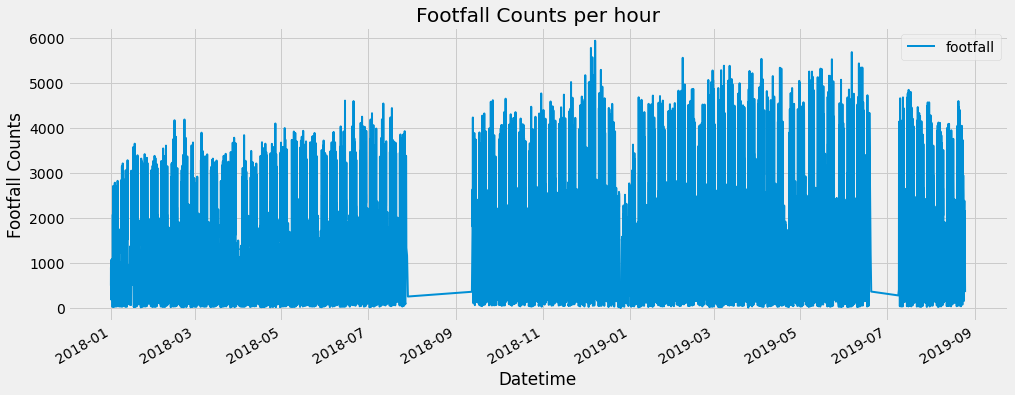

In [31]:
ff639['footfall'].plot(figsize = (15,6), title = 'Footfall Counts per hour', fontsize = 14, linewidth = 2)
plt.xlabel('Datetime')
plt.ylabel('Footfall Counts')
plt.legend(loc = 'best')

In [8]:
ff639 = ff639.resample('H').mean()
ff639['footfall'].replace(0, np.nan, inplace = True)
ff639['footfall'] = ff639['footfall'].interpolate(method='linear')
ff639 = ff639.reset_index(level = ['timestamp'])
ff639.timestamp = pd.to_datetime(ff639.timestamp, format = '%Y-%m-%d %H:%M:%S')
ff639

,timestamp,footfall,year,month,day,hour,day_of_week
0,2018-01-01 00:00:00,129.0,2018.0,1.0,1.0,0.0,1.0
1,2018-01-01 01:00:00,127.0,2018.0,1.0,1.0,1.0,1.0
2,2018-01-01 02:00:00,121.0,2018.0,1.0,1.0,2.0,1.0
3,2018-01-01 03:00:00,110.0,2018.0,1.0,1.0,3.0,1.0
4,2018-01-01 04:00:00,83.0,2018.0,1.0,1.0,4.0,1.0
...,...,...,...,...,...,...,...
14420,2019-08-24 20:00:00,165.0,2019.0,8.0,24.0,20.0,6.0
14421,2019-08-24 21:00:00,151.0,2019.0,8.0,24.0,21.0,6.0
14422,2019-08-24 22:00:00,130.0,2019.0,8.0,24.0,22.0,6.0
14423,2019-08-24 23:00:00,124.0,2019.0,8.0,24.0,23.0,6.0


In [9]:
temp = ff639[['timestamp', 'footfall']]
temp.index = temp.timestamp
temp['year'] = temp.timestamp.dt.year
temp['month'] = temp.timestamp.dt.month
temp['day'] = temp.timestamp.dt.day
temp['hour'] = temp.timestamp.dt.hour
temp['day_of_week'] = temp.timestamp.dt.dayofweek + 1
temp

,timestamp,footfall,year,month,day,hour,day_of_week
timestamp,,,,,,,
2018-01-01 00:00:00,2018-01-01 00:00:00,129.0,2018,1,1,0,1
2018-01-01 01:00:00,2018-01-01 01:00:00,127.0,2018,1,1,1,1
2018-01-01 02:00:00,2018-01-01 02:00:00,121.0,2018,1,1,2,1
2018-01-01 03:00:00,2018-01-01 03:00:00,110.0,2018,1,1,3,1
2018-01-01 04:00:00,2018-01-01 04:00:00,83.0,2018,1,1,4,1
...,...,...,...,...,...,...,...
2019-08-24 20:00:00,2019-08-24 20:00:00,165.0,2019,8,24,20,6
2019-08-24 21:00:00,2019-08-24 21:00:00,151.0,2019,8,24,21,6
2019-08-24 22:00:00,2019-08-24 22:00:00,130.0,2019,8,24,22,6


In [10]:
ff639 = temp

### Hourly Distribution by Day of Week

#### Overall Distribution:

<AxesSubplot:xlabel='hour'>

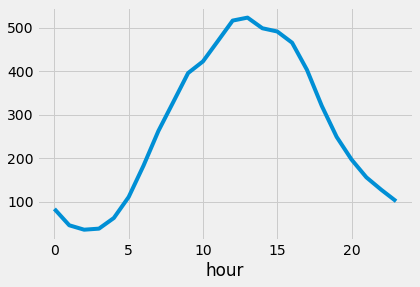

In [10]:
ff639.groupby('hour')['footfall'].mean().plot.line()

#### Monday to Friday Distribution:

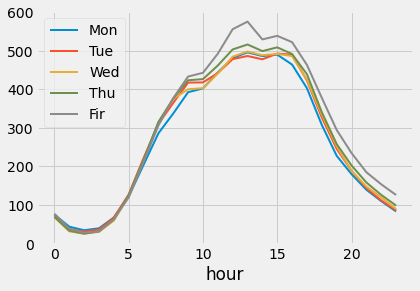

In [11]:
weekday = 1
ff639.loc[(ff639.day_of_week >= weekday) & (ff639.day_of_week <= weekday)].groupby('hour')['footfall'].mean().plot(
    label = 'Mon', linewidth = 2)

weekday = 2
ff639.loc[(ff639.day_of_week >= weekday) & (ff639.day_of_week <= weekday)].groupby('hour')['footfall'].mean().plot(
    label = 'Tue', linewidth = 2)

weekday = 3
ff639.loc[(ff639.day_of_week >= weekday) & (ff639.day_of_week <= weekday)].groupby('hour')['footfall'].mean().plot(
    label = 'Wed', linewidth = 2)

weekday = 4
ff639.loc[(ff639.day_of_week >= weekday) & (ff639.day_of_week <= weekday)].groupby('hour')['footfall'].mean().plot(
    label = 'Thu', linewidth = 2)

weekday = 5
ff639.loc[(ff639.day_of_week >= weekday) & (ff639.day_of_week <= weekday)].groupby('hour')['footfall'].mean().plot(
    label = 'Fir', linewidth = 2)

plt.legend(loc = 'best')

#### Saturday & Sunday Distribution:

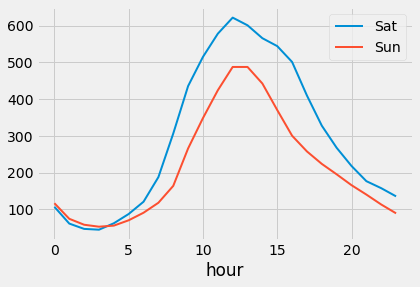

In [12]:
weekday = 6
ff639.loc[(ff639.day_of_week >= weekday) & (ff639.day_of_week <= weekday)].groupby('hour')['footfall'].mean().plot(
    label = 'Sat', linewidth = 2)

weekday = 7
ff639.loc[(ff639.day_of_week >= weekday) & (ff639.day_of_week <= weekday)].groupby('hour')['footfall'].mean().plot(
    label = 'Sun', linewidth = 2)

plt.legend(loc = 'best')

### Divide Data into Training and Validation

In [11]:
Train = ff639.loc[(ff639.timestamp >= '2018-01-01 00:00') & (ff639.timestamp <= '2019-07-28 23:00')]
Valid = ff639.loc[(ff639.timestamp >= '2019-07-29 00:00') & (ff639.timestamp <= '2019-08-18 23:00')]

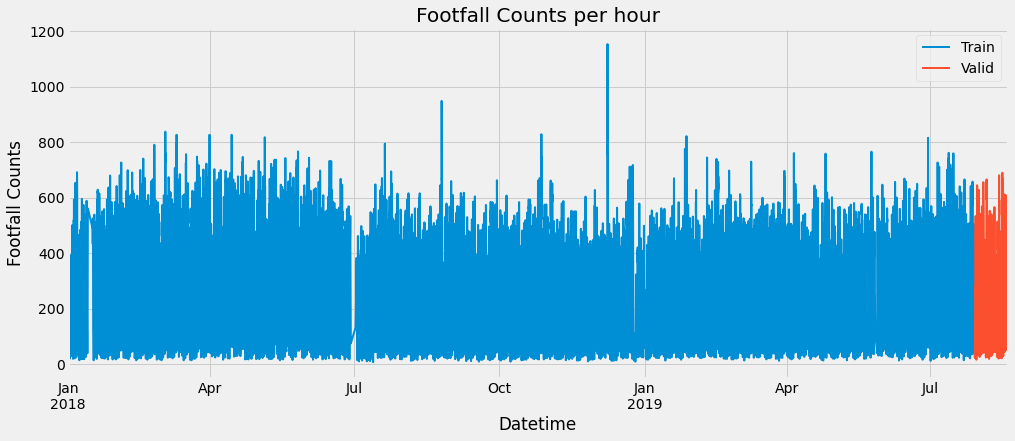

In [12]:
Train['footfall'].plot(figsize = (15,6), title = 'Footfall Counts per hour', fontsize = 14, label = 'Train', linewidth = 2)
Valid['footfall'].plot(figsize = (15,6), title = 'Footfall Counts per hour', fontsize =14, label = 'Valid', linewidth = 2)
plt.xlabel('Datetime')
plt.ylabel('Footfall Counts')
plt.legend(loc = 'best')

### Convert to Daily Mean and Calc Hourly Ratio by Day of Week

In [24]:
train = Train.resample('D').mean()
valid = Valid.resample('D').mean() 

In [25]:
train['footfall'] = train['footfall'].interpolate(method='linear')
valid['footfall'] = valid['footfall'].interpolate(method='linear')

In [ ]:
train['year'] = train.timestamp.dt.year
train['month'] = train.timestamp.dt.month
train['day'] = train.timestamp.dt.day
train['hour'] = train.timestamp.dt.hour
train['day_of_week'] = train.timestamp.dt.dayofweek + 1

valid.index = valid.timestamp
valid['year'] = valid.timestamp.dt.year
valid['month'] = valid.timestamp.dt.month
valid['day'] = valid.timestamp.dt.day
valid['hour'] = valid.timestamp.dt.hour
valid['day_of_week'] = valid.timestamp.dt.dayofweek + 1

In [33]:
# Monday to Friday Ratio
mtf = Train.loc[(Train.day_of_week >= 1) & (Train.day_of_week <= 5)].groupby('hour')['footfall'].mean().to_frame()
mtf['ratio'] = mtf['footfall']/mtf['footfall'].sum()
mtf = mtf.reset_index(level = ['hour'])

# Weekend Ratio
weekend = Train.loc[(Train.day_of_week >= 6) & (Train.day_of_week <= 7)].groupby('hour')['footfall'].mean().to_frame()
weekend['ratio'] = weekend['footfall']/weekend['footfall'].sum()
weekend = weekend.reset_index(level = ['hour'])

ratio1 = mtf[['hour','ratio']]
ratio1['day_of_week'] = 1
ratio2 = mtf[['hour','ratio']]
ratio2['day_of_week'] = 2
ratio3 = mtf[['hour','ratio']]
ratio3['day_of_week'] = 3
ratio4 = mtf[['hour','ratio']]
ratio4['day_of_week'] = 4
ratio5 = mtf[['hour','ratio']]
ratio5['day_of_week'] = 5
ratio6 = weekend[['hour','ratio']]
ratio6['day_of_week'] = 6
ratio7 = weekend[['hour','ratio']]
ratio7['day_of_week'] = 7

ratio_week = ratio1.append(ratio2).append(ratio3).append(ratio4).append(ratio5).append(ratio6).append(ratio7)

merge = pd.merge(Valid, ratio_week, on = ('hour','day_of_week'), how = 'left')
merge

,timestamp,footfall,year,month,day,hour,day_of_week,ratio
0,2019-07-29 00:00:00,50.0,2019,7,29,0,1,0.010848
1,2019-07-29 01:00:00,39.0,2019,7,29,1,1,0.005538
2,2019-07-29 02:00:00,22.0,2019,7,29,2,1,0.004310
3,2019-07-29 03:00:00,23.0,2019,7,29,3,1,0.005011
4,2019-07-29 04:00:00,69.0,2019,7,29,4,1,0.009494
...,...,...,...,...,...,...,...,...
499,2019-08-18 19:00:00,206.0,2019,8,18,19,7,0.038047
500,2019-08-18 20:00:00,175.0,2019,8,18,20,7,0.031561
501,2019-08-18 21:00:00,113.0,2019,8,18,21,7,0.026089
502,2019-08-18 22:00:00,98.0,2019,8,18,22,7,0.022315


In [34]:
# Monday to Thursday Ratio
mtt = Train.loc[(Train.day_of_week >= 1) & (Train.day_of_week <= 4)].groupby('hour')['footfall'].mean().to_frame()
mtt['ratio'] = mtt['footfall']/mtt['footfall'].sum()
mtt = mtt.reset_index(level = ['hour'])

# Friday Ratio
fri = Train.loc[(Train.day_of_week >= 5) & (Train.day_of_week <= 5)].groupby('hour')['footfall'].mean().to_frame()
fri['ratio'] = fri['footfall']/fri['footfall'].sum()
fri = fri.reset_index(level = ['hour'])

# Sat Ratio
sat = Train.loc[(Train.day_of_week >= 6) & (Train.day_of_week <= 6)].groupby('hour')['footfall'].mean().to_frame()
sat['ratio'] = sat['footfall']/sat['footfall'].sum()
sat = sat.reset_index(level = ['hour'])

# Sun Ratio
sun = Train.loc[(Train.day_of_week >= 7) & (Train.day_of_week <= 7)].groupby('hour')['footfall'].mean().to_frame()
sun['ratio'] = sun['footfall']/sun['footfall'].sum()
sun = sun.reset_index(level = ['hour'])

ratio1 = mtt[['hour','ratio']]
ratio1['day_of_week'] = 1
ratio2 = mtt[['hour','ratio']]
ratio2['day_of_week'] = 2
ratio3 = mtt[['hour','ratio']]
ratio3['day_of_week'] = 3
ratio4 = mtt[['hour','ratio']]
ratio4['day_of_week'] = 4
ratio5 = fri[['hour','ratio']]
ratio5['day_of_week'] = 5
ratio6 = sat[['hour','ratio']]
ratio6['day_of_week'] = 6
ratio7 = sun[['hour','ratio']]
ratio7['day_of_week'] = 7

ratio_week = ratio1.append(ratio2).append(ratio3).append(ratio4).append(ratio5).append(ratio6).append(ratio7)

merge2 = pd.merge(Valid, ratio_week, on = ('hour','day_of_week'), how = 'left')
merge2

,timestamp,footfall,year,month,day,hour,day_of_week,ratio
0,2019-07-29 00:00:00,50.0,2019,7,29,0,1,0.010876
1,2019-07-29 01:00:00,39.0,2019,7,29,1,1,0.005603
2,2019-07-29 02:00:00,22.0,2019,7,29,2,1,0.004449
3,2019-07-29 03:00:00,23.0,2019,7,29,3,1,0.005226
4,2019-07-29 04:00:00,69.0,2019,7,29,4,1,0.009734
...,...,...,...,...,...,...,...,...
499,2019-08-18 19:00:00,206.0,2019,8,18,19,7,0.038102
500,2019-08-18 20:00:00,175.0,2019,8,18,20,7,0.032351
501,2019-08-18 21:00:00,113.0,2019,8,18,21,7,0.027432
502,2019-08-18 22:00:00,98.0,2019,8,18,22,7,0.022221


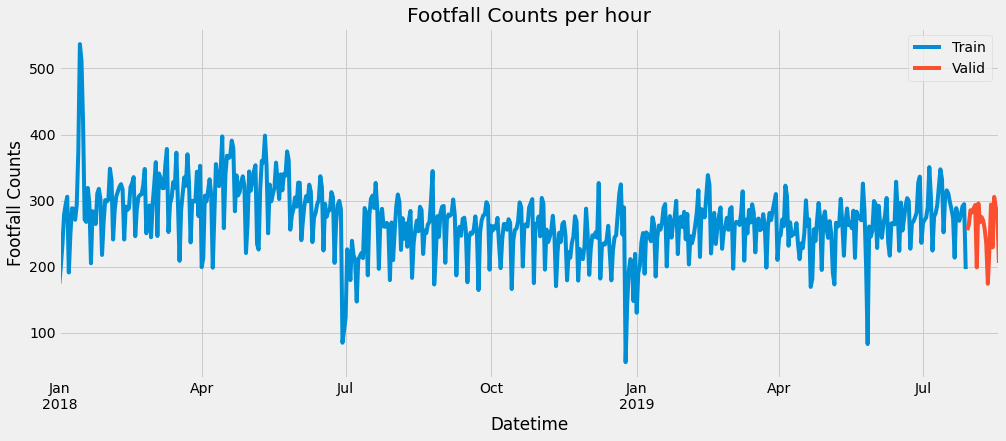

In [35]:
train['footfall'].plot(figsize = (15,6), title = 'Footfall Counts per hour', fontsize = 14, label = 'Train')
valid['footfall'].plot(figsize = (15,6), title = 'Footfall Counts per hour', fontsize =14, label = 'Valid')
plt.xlabel('Datetime')
plt.ylabel('Footfall Counts')
plt.legend(loc = 'best')

In [36]:
from math import sqrt

def rmse(y_true, y_pred):
    squared_error = 0
    for i in range(len(y_true)):
        squared_error = squared_error + (y_true[i] - y_pred[i]) ** 2
    root_mean_squared_error = sqrt(squared_error / len(y_true))
    return root_mean_squared_error

### 1. Naive Approach

RMSE for Naive approach is 34.58893266011742


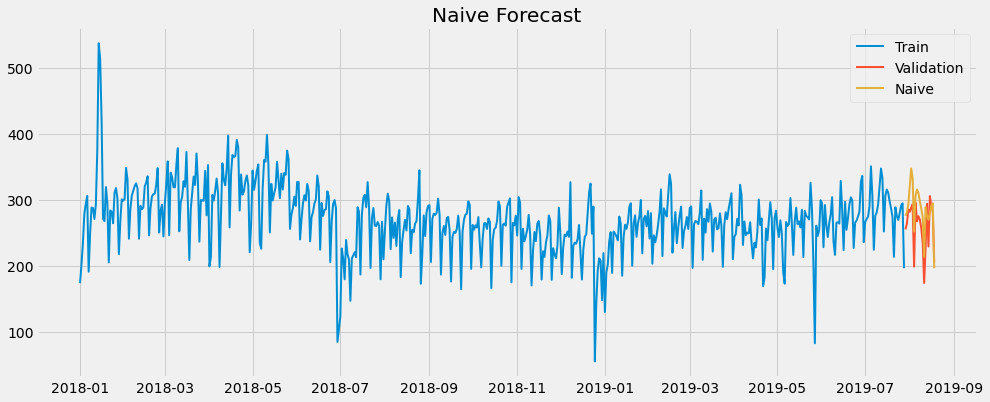

In [37]:
dd = np.asarray(train['footfall'])
y_hat = valid.copy()
y_hat['naive']= dd[len(dd)- 1]
for i in range(len(valid)): 
    y_hat['naive'][i]= dd[len(dd) - len(valid) + i]
    
plt.figure(figsize = (15,6))
plt.plot(train.index, train['footfall'], label = 'Train', linewidth = 2)
plt.plot(valid.index, valid['footfall'], label = 'Validation', linewidth = 2)
plt.plot(y_hat.index, y_hat['naive'], label = 'Naive', linewidth = 2)
plt.legend(loc = 'best')
plt.title('Naive Forecast')

naive_rmse = rmse(valid.footfall, y_hat.naive)
print('RMSE for Naive approach is',naive_rmse)

### 2. Moving Average Approach
#### Consider Seasonality (Weekly Fluctuations)

In [38]:
def moving_avg(rounds):
    y_hat['avg'] = 0
    for i in range(len(valid)):
        y_pred = 0
        for j in range(rounds):
            y_pred = y_pred + train.footfall[len(train) - (j + 1) * len(valid) + i]
        y_hat['avg'][i] = y_pred / rounds
    
    plt.figure(figsize = (15,5))
    plt.plot(train.footfall, label = 'Train', linewidth = 2)
    plt.plot(valid.footfall, label = 'Validation', linewidth = 2)
    plt.plot(y_hat['avg'], label = 'Monving Average Forecast with ' + str(3 * rounds) + ' Weeks Observations', linewidth = 2)
    plt.legend(loc = 'best')
    plt.show()
    
    avg_rmse = rmse(valid.footfall, y_hat.avg)
    print('RMSE equals', avg_rmse)

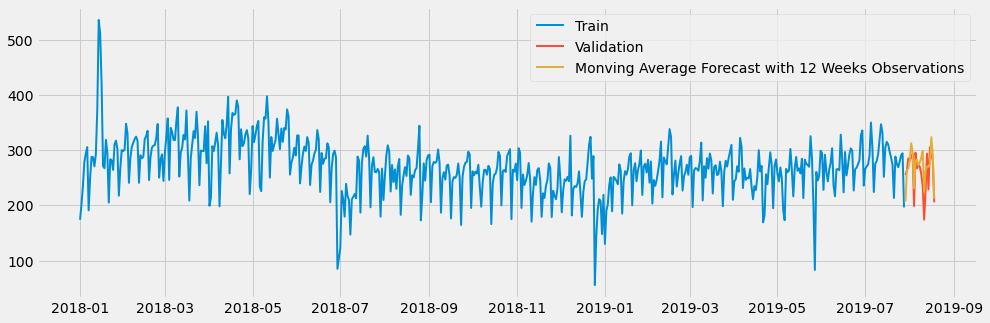

RMSE equals 29.190438158653595


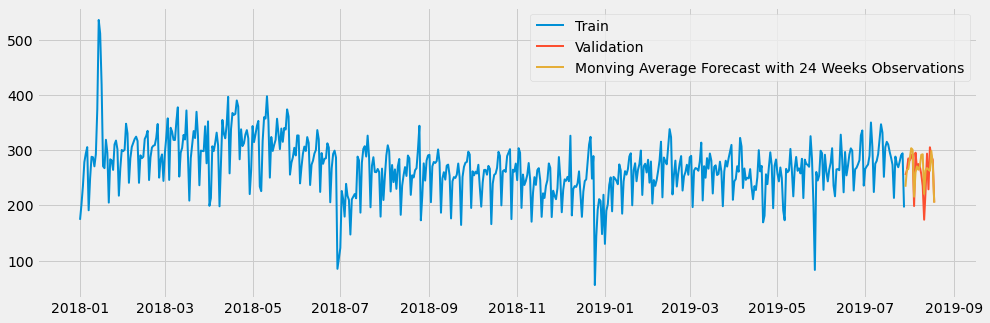

RMSE equals 26.595111089492253


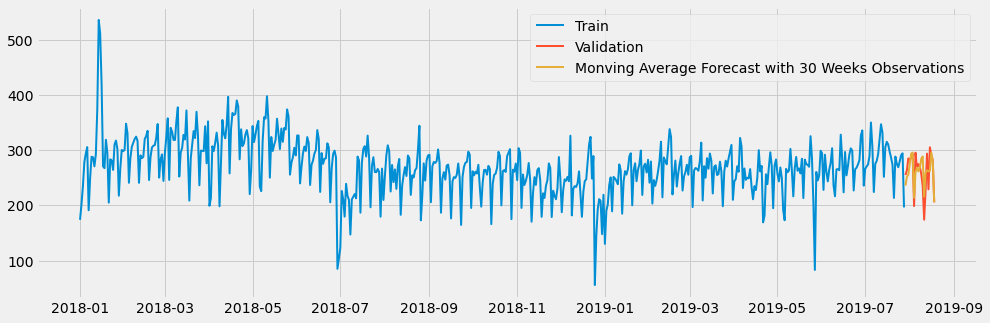

RMSE equals 25.34074009309137


In [39]:
moving_avg(4)
avg_rmse4 = rmse(valid.footfall, y_hat.avg)
moving_avg(8)
avg_rmse8 = rmse(valid.footfall, y_hat.avg)
moving_avg(10)
avg_rmse10 = rmse(valid.footfall, y_hat.avg)

### 3. Exponential Smoothing
#### Holt-Winters’ Seasonal Method

RMSE for Holt Winters seasonal forecast is  24.92102997132646


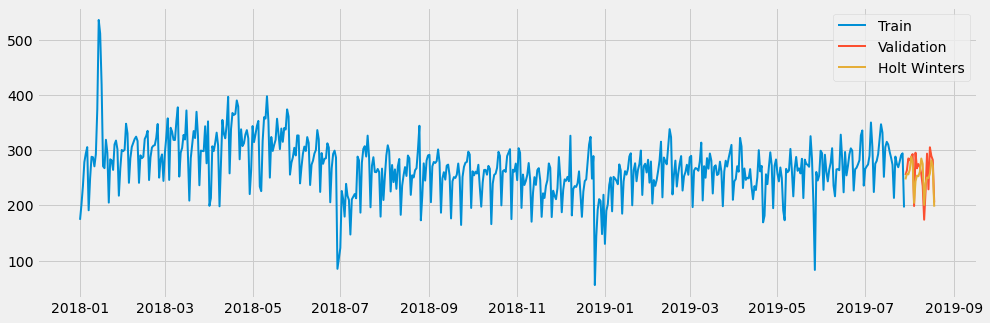

In [40]:
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing, Holt

y_hat = valid.copy()
fit1 = ExponentialSmoothing(np.asarray(train.footfall), seasonal_periods = 7, trend = 'add', seasonal= 'add').fit()
y_hat['Holt_Winter'] = fit1.forecast(len(valid))

plt.figure(figsize = (15,5))
plt.plot(train.footfall, label = 'Train', linewidth = 2)
plt.plot(valid.footfall, label = 'Validation', linewidth = 2)
plt.plot(y_hat.Holt_Winter, label = 'Holt Winters', linewidth = 2)
plt.legend(loc = 'best')

rmse_hw = rmse(valid.footfall, y_hat.Holt_Winter)
print('RMSE for Holt Winters seasonal forecast is ', rmse_hw)

#### Covert to Hourly Predictions:

In [41]:
pred_d = y_hat.Holt_Winter.to_frame()
pred_d = pred_d.reset_index(level = ['timestamp'])
pred_d['month'] = pred_d.timestamp.dt.month
pred_d['day'] = pred_d.timestamp.dt.day

temp = pd.merge(merge, pred_d, on = ('month','day'), how = 'left')
temp['prediction'] = temp['ratio'] * temp['Holt_Winter'] * 24

holt_winter_rmse = rmse(temp['footfall'], temp['prediction'])
print('RMSE for Holt Winters seasonal forecast is ', holt_winter_rmse)

RMSE for Holt Winters seasonal forecast is  54.52471210443779


In [42]:
temp2 = pd.merge(merge2, pred_d, on = ('month','day'), how = 'left')
temp2['prediction'] = temp2['ratio'] * temp2['Holt_Winter'] * 24

holt_winter_rmse2 = rmse(temp2['footfall'], temp2['prediction'])
print('RMSE for Holt Winters seasonal forecast is ', holt_winter_rmse2)

RMSE for Holt Winters seasonal forecast is  54.00685100687783


### 4. ARIMA Model

In [43]:
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries):
    #Determine rolling statistics
    rolmean = pd.Series(timeseries).rolling(window = 28).mean()
    rolstd = pd.Series(timeseries).rolling(window = 28).std()
    
    #Plot rolling Statistics
    orig = plt.plot(timeseries, color = "blue", label = "Original")
    mean = plt.plot(rolmean, color = "red", label = "Rolling Mean")
    std = plt.plot(rolstd, color = "black", label = "Rolling Std")
    plt.legend(loc = "best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block = False)
    
    #Perform Dickey Fuller test
    print("Results of Dickey Fuller test: ")
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistics', 'p-value', '# Lag Used', 'Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

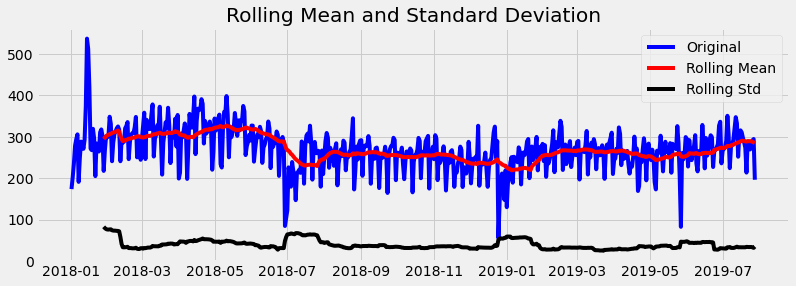

Results of Dickey Fuller test: 
Test Statistics                 -2.678953
p-value                          0.077752
# Lag Used                      19.000000
Number of Observations Used    554.000000
Critical Value (1%)             -3.442209
Critical Value (5%)             -2.866771
Critical Value (10%)            -2.569556
dtype: float64


In [44]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (12,4)
test_stationary(train['footfall'])

The footfall data is unstationary according to the result.

#### *Decompose:*

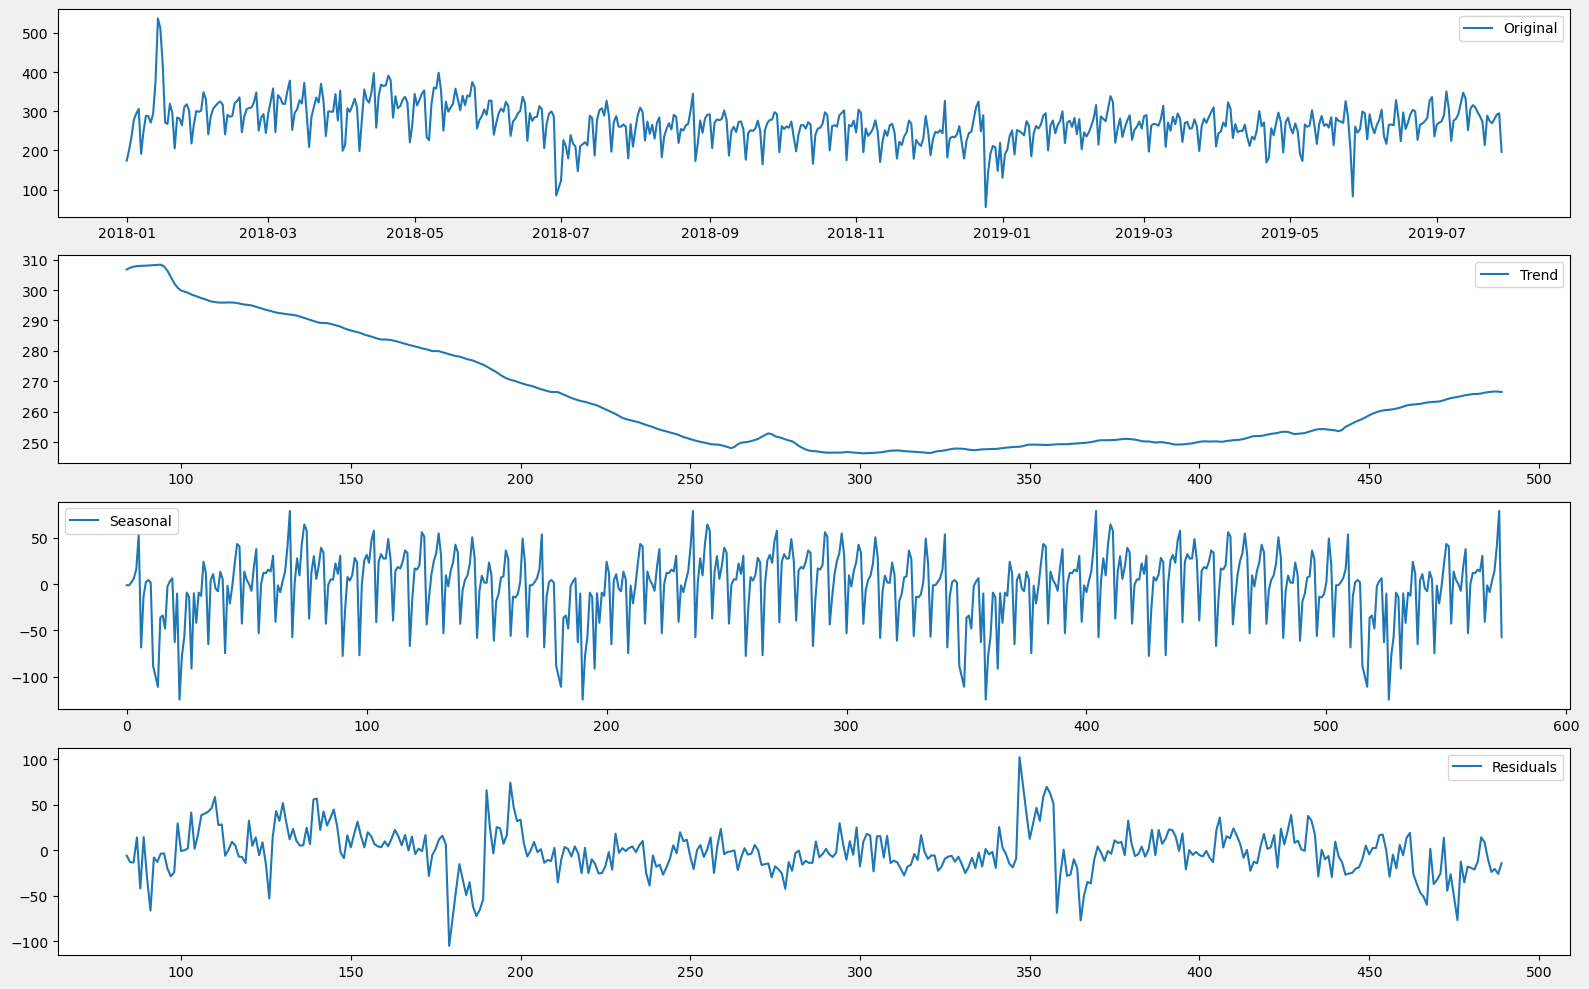

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize = (16,10))
decomposition = seasonal_decompose(pd.DataFrame(train).footfall.values, freq = 168) # 1 week
plt.style.use('default')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(train.footfall, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

#### ***Stationarity of residuals:***

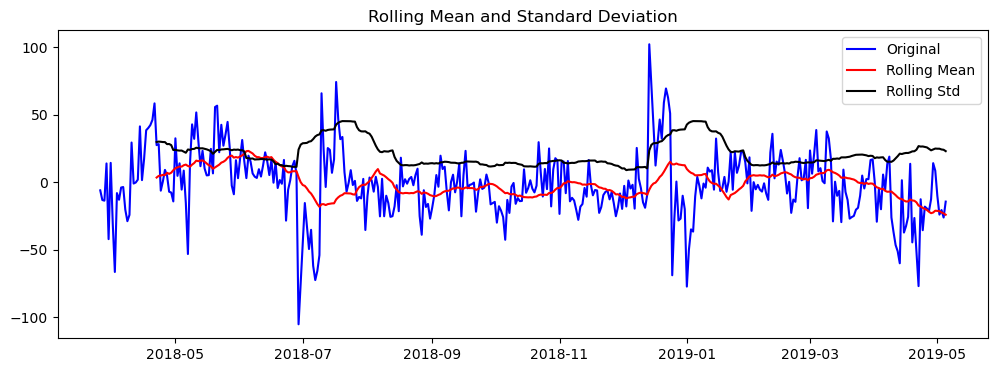

Results of Dickey Fuller test: 
Test Statistics                 -5.321501
p-value                          0.000005
# Lag Used                      11.000000
Number of Observations Used    394.000000
Critical Value (1%)             -3.447057
Critical Value (5%)             -2.868904
Critical Value (10%)            -2.570693
dtype: float64


In [40]:
plt.figure(figsize = (12,4))
train_decompose = pd.DataFrame(residual)
train_decompose['date'] = train.index
train_decompose.set_index('date', inplace = True)
train_decompose.dropna(inplace = True)
test_stationary(train_decompose[0])

#### ***Differncing Analyzing:***

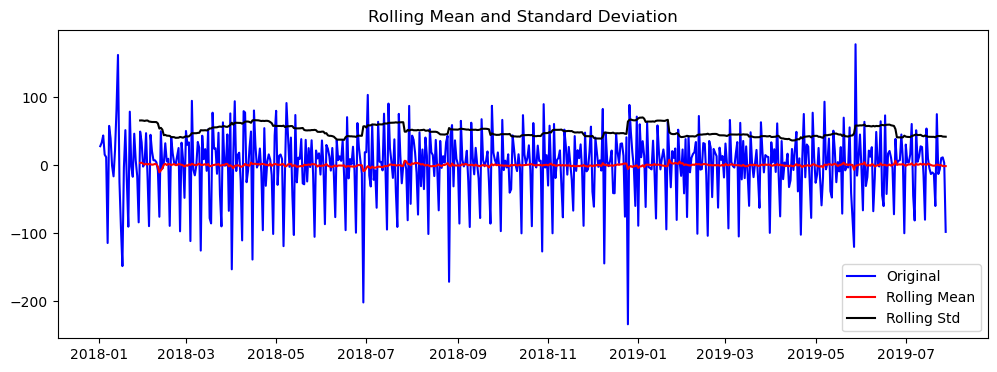

Results of Dickey Fuller test: 
Test Statistics               -9.793847e+00
p-value                        6.249866e-17
# Lag Used                     1.900000e+01
Number of Observations Used    5.530000e+02
Critical Value (1%)           -3.442230e+00
Critical Value (5%)           -2.866781e+00
Critical Value (10%)          -2.569561e+00
dtype: float64


In [41]:
train_diff = train['footfall'] - train['footfall'].shift(1)
rcParams['figure.figsize'] = (12,4)
test_stationary(train_diff.dropna())

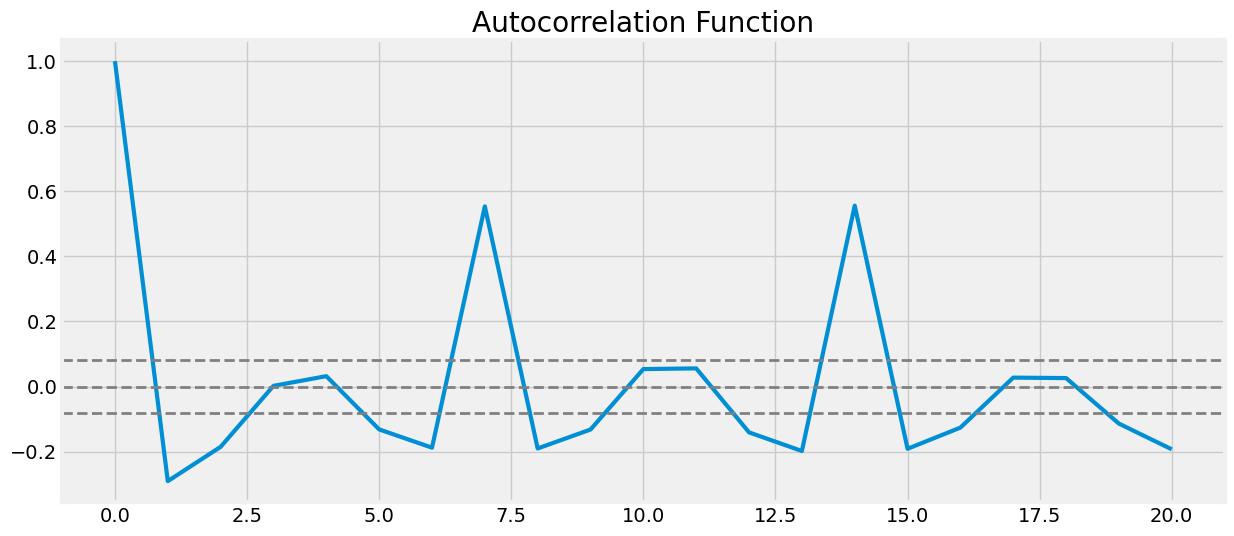

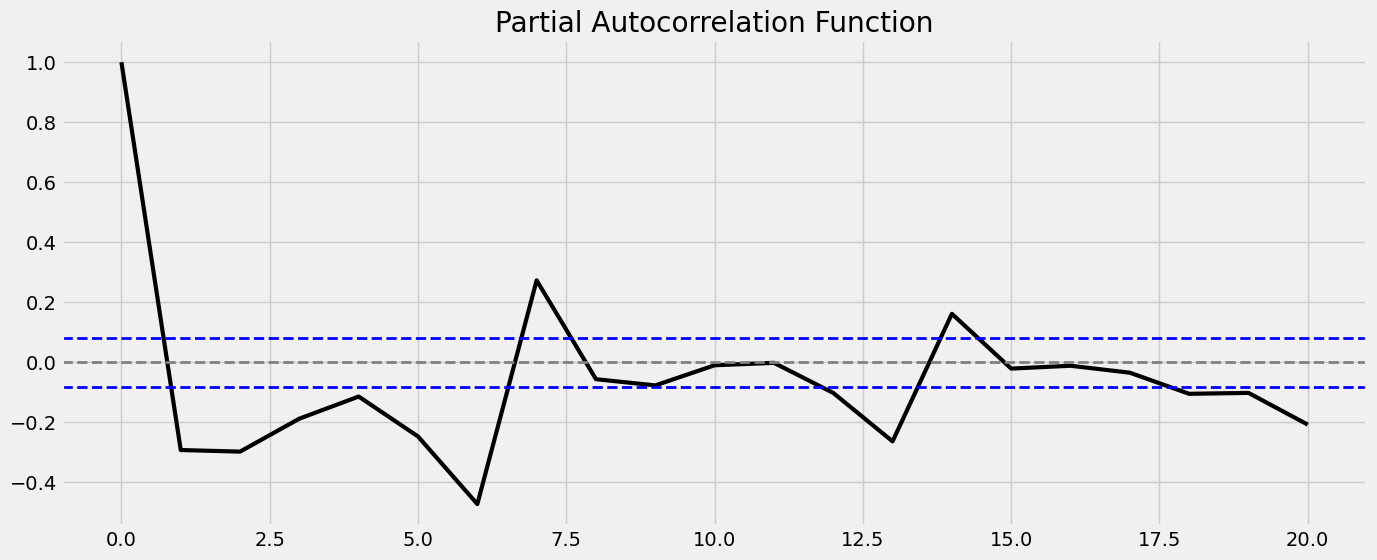

In [42]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(train_diff.dropna(), nlags = 20)
lag_pacf = pacf(train_diff.dropna(), nlags = 20, method= "ols")

plt.figure(figsize = (15,6))
plt.style.use("fivethirtyeight")
plt.plot(lag_acf, linewidth = 3)
plt.axhline( y = 0, linestyle = "--", color = "gray", linewidth = 2)
plt.axhline( y= -1.96/np.sqrt(len(train_diff.dropna())), linestyle = "--", color = "gray", linewidth = 2)
plt.axhline(y = 1.96 /np.sqrt(len(train_diff.dropna())), linestyle = "--", color = "gray", linewidth = 2)
plt.title("Autocorrelation Function")
plt.show()

# PACF
plt.figure(figsize = (15,6))
plt.plot(lag_pacf, linewidth = 3, color = 'black')
plt.axhline(y = 0, linestyle = "--", color = "gray", linewidth = 2)
plt.axhline(y = -1.96/np.sqrt(len(train_diff.dropna())), linestyle = "--", color = "blue", linewidth = 2)
plt.axhline( y = 1.96/np.sqrt(len(train_diff.dropna())), linestyle = "--", color = "blue", linewidth = 2)
plt.title("Partial Autocorrelation Function")
plt.show()

In [43]:
import statsmodels.api as sm

arma_mod02 = sm.tsa.ARMA(train_diff.fillna(0),(4,3)).fit() 
print("arma_mod:",arma_mod02.aic,arma_mod02.bic,arma_mod02.hqic) 

arma_mod60 = sm.tsa.ARMA(train_diff.fillna(0),(4,4)).fit() 
print("arma_mod:",arma_mod60.aic,arma_mod60.bic,arma_mod60.hqic) 
  
arma_mod70 = sm.tsa.ARMA(train_diff.fillna(0),(4,7)).fit() 
print("arma_mod:",arma_mod70.aic,arma_mod70.bic,arma_mod70.hqic) 

LinAlgError: SVD did not converge

#### ***Seasonal Analyzing:***

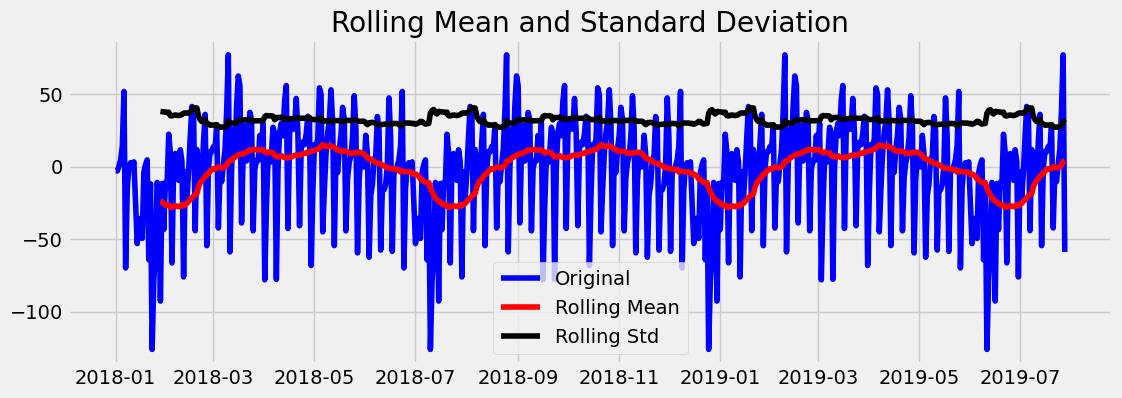

Results of Dickey Fuller test: 
Test Statistics                 -4.349528
p-value                          0.000364
# Lag Used                      16.000000
Number of Observations Used    557.000000
Critical Value (1%)             -3.442145
Critical Value (5%)             -2.866743
Critical Value (10%)            -2.569541
dtype: float64


In [68]:
plt.figure(figsize = (12,4))
train_decompose = pd.DataFrame(seasonal)
train_decompose['date'] = train.index
train_decompose.set_index('date', inplace = True)
train_decompose.dropna(inplace = True)
test_stationary(train_decompose[0])

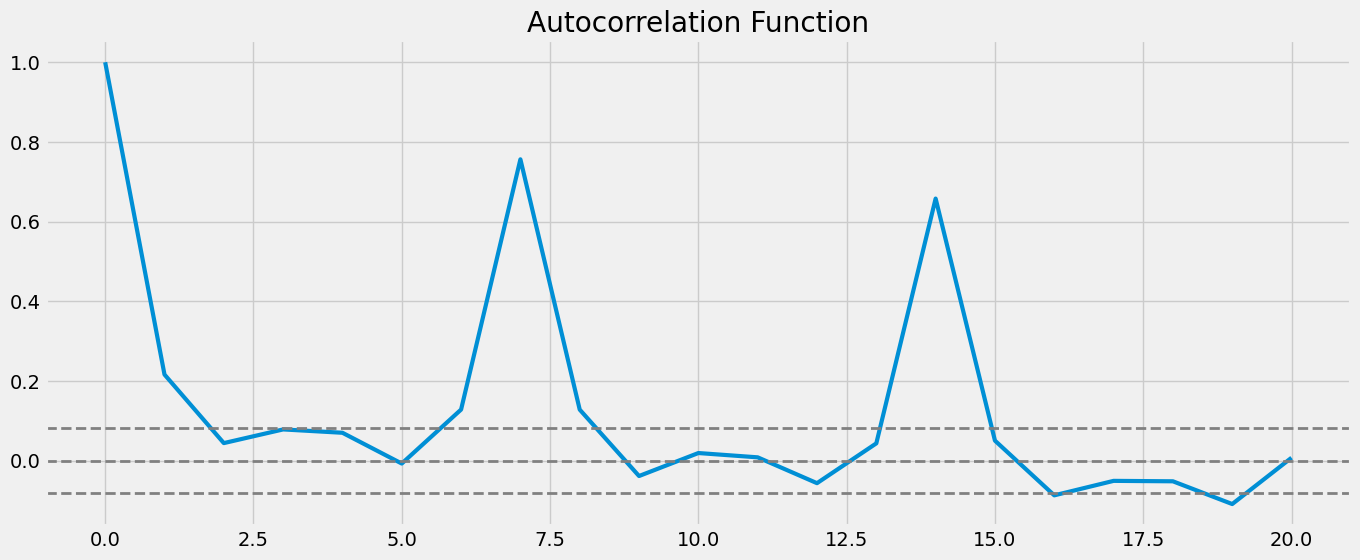

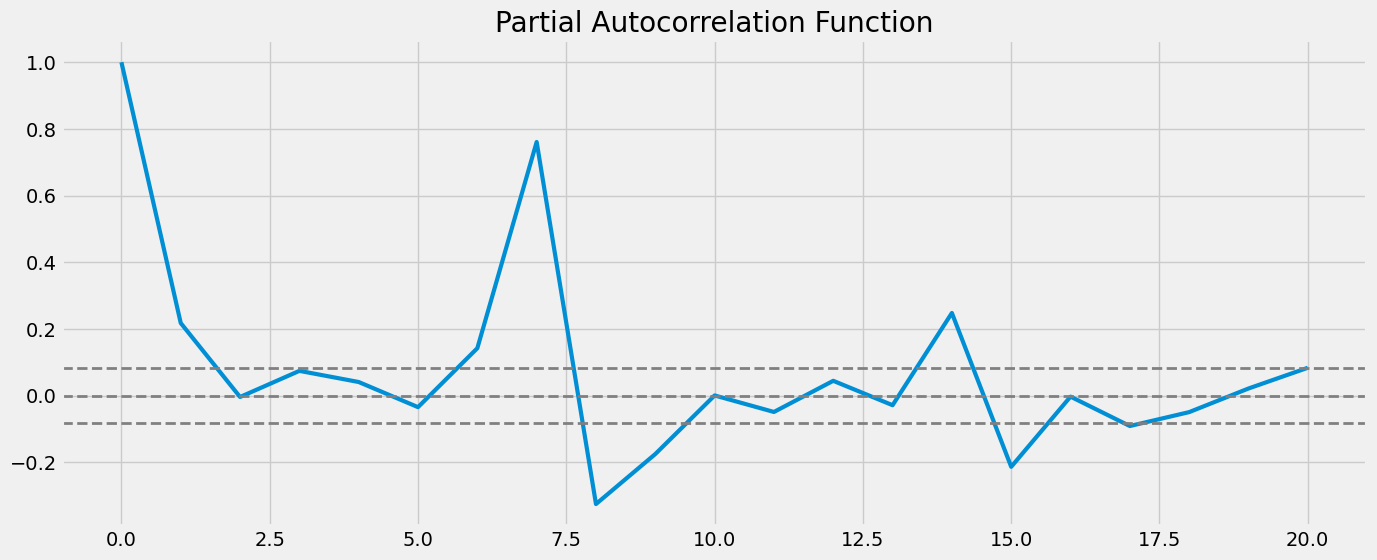

In [70]:
lag_acf = acf(train_decompose.dropna(), nlags = 20)
lag_pacf = pacf(train_decompose.dropna(), nlags = 20, method= "ols")

plt.figure(figsize = (15,6))
plt.style.use("fivethirtyeight")
plt.plot(lag_acf, linewidth = 3)
plt.axhline( y = 0, linestyle = "--", color = "gray", linewidth = 2)
plt.axhline( y= -1.96/np.sqrt(len(train_decompose.dropna())), linestyle = "--", color = "gray", linewidth = 2)
plt.axhline(y = 1.96 /np.sqrt(len(train_decompose.dropna())), linestyle = "--", color = "gray", linewidth = 2)
plt.title("Autocorrelation Function")
plt.show()

# PACF
plt.figure(figsize = (15,6))
plt.plot(lag_pacf, linewidth = 3)
plt.axhline(y = 0, linestyle = "--", color = "gray", linewidth = 2)
plt.axhline(y = -1.96/np.sqrt(len(train_decompose.dropna())), linestyle = "--", color = "gray", linewidth = 2)
plt.axhline( y = 1.96/np.sqrt(len(train_decompose.dropna())), linestyle = "--", color = "gray", linewidth = 2)
plt.title("Partial Autocorrelation Function")
plt.show()

### SARIMA Model

In [90]:
import itertools
d = (1,1)
p = q = range(5, 7)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]

In [91]:
best_aic = 10000
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train['footfall'],
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
 
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(1, 1, 1)x(1, 1, 1, 7)7 - AIC:5166.269917237569
ARIMA(1, 1, 1)x(1, 1, 2, 7)7 - AIC:5097.853200127478
ARIMA(1, 1, 1)x(1, 1, 3, 7)7 - AIC:5023.430539954447
ARIMA(1, 1, 1)x(1, 1, 4, 7)7 - AIC:4957.390630226722


E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

ARIMA(1, 1, 2)x(1, 1, 4, 7)7 - AIC:4942.539450181066


E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

ARIMA(1, 1, 2)x(3, 1, 4, 7)7 - AIC:4939.5220858300545


E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

ARIMA(1, 1, 3)x(1, 1, 4, 7)7 - AIC:4933.175746291447


E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

ARIMA(1, 1, 4)x(1, 1, 4, 7)7 - AIC:4927.0027502826215


E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:5

ARIMA(1, 1, 4)x(1, 1, 4, 7)7 - AIC:4927.0027502826215

E:\Anaconda3\envs\urbsim\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


RMSE for SARIMA forecast is  28.580035058471147


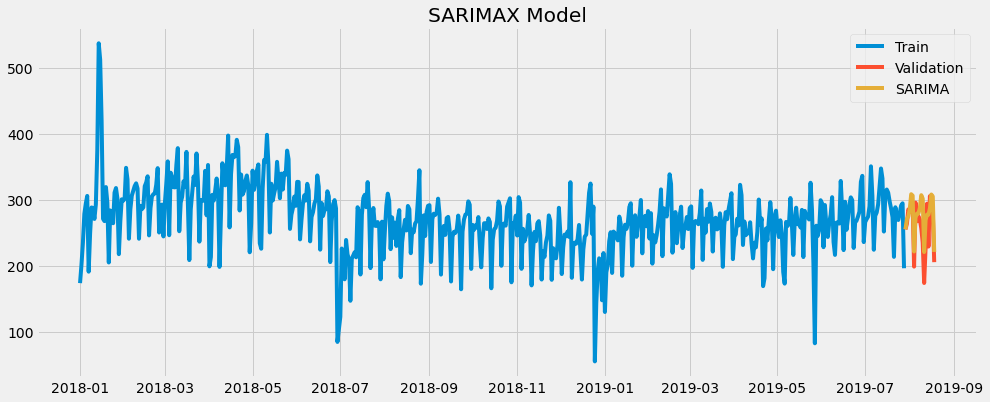

In [58]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

fit1 = sm.tsa.statespace.SARIMAX(train.footfall, order = (1,1,3), seasonal_order =(1,1,3,7)).fit()
y_hat['SARIMA'] = fit1.predict(start = "2019-07-29 00:00", end = "2019-08-18 23:00", dynamic=True)
plt.figure(figsize=(15,6))
plt.plot(train['footfall'], label = "Train")
plt.plot(valid['footfall'], label = "Validation")
plt.plot(y_hat['SARIMA'], label ="SARIMA")
plt.legend(loc = "best")
plt.title("SARIMAX Model")

rmse_sarima = rmse(valid['footfall'], y_hat['SARIMA'])
print('RMSE for SARIMA forecast is ', rmse_sarima)

In [59]:
pred_d = y_hat['SARIMA'].to_frame()
pred_d = pred_d.reset_index(level = ['timestamp'])
pred_d['month'] = pred_d.timestamp.dt.month
pred_d['day'] = pred_d.timestamp.dt.day

temp3 = pd.merge(merge2, pred_d, on = ('month','day'), how = 'left')
temp3['prediction'] = temp2['ratio'] * temp3['SARIMA'] * 24

rmse_sarimax3 = rmse(temp3['footfall'], temp3['prediction'])
print('RMSE for SARIMA forecast is', rmse_sarimax3)

RMSE for SARIMA forecast is 55.60219954083493


RMSE for SARIMA forecast is  36.59793222350418


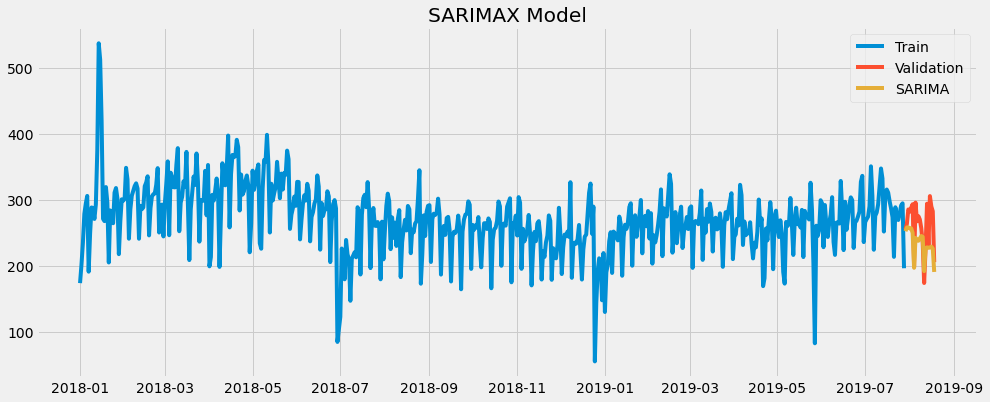

In [47]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

fit1 = sm.tsa.statespace.SARIMAX(train.footfall, order = (5,1,0), seasonal_order =(2,0,0,7)).fit()
y_hat['SARIMA'] = fit1.predict(start = "2019-07-29 00:00", end = "2019-08-18 23:00", dynamic=True)

plt.figure(figsize=(15,6))
plt.plot(train['footfall'], label = "Train")
plt.plot(valid['footfall'], label = "Validation")
plt.plot(y_hat['SARIMA'], label ="SARIMA")
plt.legend(loc = "best")
plt.title("SARIMA Model")

rmse_sarima = rmse(valid['footfall'], y_hat['SARIMA'])
print('RMSE for SARIMA forecast is ', rmse_sarima)

In [50]:
pred_d = y_hat['SARIMA'].to_frame()
pred_d = pred_d.reset_index(level = ['timestamp'])
pred_d['month'] = pred_d.timestamp.dt.month
pred_d['day'] = pred_d.timestamp.dt.day

temp4 = pd.merge(merge2, pred_d, on = ('month','day'), how = 'left')
temp4['prediction'] = temp2['ratio'] * temp4['SARIMA'] * 24

rmse_sarimax3 = rmse(temp4['footfall'], temp4['prediction'])
print('RMSE for SARIMA forecast is', rmse_sarimax3)

RMSE for SARIMA forecast is 62.858279835714676


RMSE for SARIMAX forecast is  29.20744723771834 (1,1,5)

- dealing with the missing data -- linear interpolation.
- exclude the locations that has too many missing data.
- have some difficulties in identify the p,q in SARIMA model.
- start with the LSTM method.
- add mean absolute percentage error.

In [52]:
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

In [60]:
rt = dm_test(temp3['footfall'], temp3['prediction'], temp4['prediction'],h = 1, crit="MSE")
rt

dm_return(DM=-2.346700638270009, p_value=0.019327490039388853)